In [1]:
import numpy as np

# tensorflow 1.15
import tensorflow as tf

# tensorflow 2.XX
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import matplotlib.pyplot as plt


In [2]:
class Convection_1D:
    def __init__(self, u_init, whole_region, BC,  layers):
        
        # u_init[x, t, u_init]

        self.x_init = u_init[:, 0:1]
        self.t_init = u_init[:, 1:2]

        self.u_init = u_init[:, 2:3]


        self.x_whole = whole_region[:, 0:1]
        self.t_whole = whole_region[:, 1:2]

        Input = np.concatenate([self.x_whole, self.t_whole], 1)


        self.Re = 100

        self.BC = BC


        self.x1_bc = self.BC[:len(BC)//2, 0:1]
        self.t1_bc = self.BC[:len(BC)//2, 1:2]
        
        self.x2_bc = self.BC[len(BC)//2:, 0:1]
        self.t2_bc = self.BC[len(BC)//2:, 1:2]


        self.lb = Input.min()
        self.ub = Input.max()

        self.layers = layers


        # Initial weights & biases
        self.weights, self.biases, self.adap = self.NN_INIT(layers)

        config=tf.ConfigProto()

        self.sess = tf.Session(config=config)
        self.saver = tf.train.Saver()
        self.learning_rate = tf.placeholder(tf.float32, shape=[])  # it can change during the training process
        self.we = tf.placeholder(tf.float32, shape = [17])
        
        # place holder
        self.xinit_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.tinit_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.uinit_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xbc1_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.tbc1_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.xbc2_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.tbc2_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xw_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.tw_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.u_tf = tf.placeholder(tf.float32, shape=[None, 1])


        #initial field
        self.uin_pred = self.BC_OUT(self.xinit_tf, self.tinit_tf)

        #boundary output
        self.ubc1_pred= self.BC_OUT(self.xbc1_tf, self.tbc1_tf)
        self.ubc2_pred= self.BC_OUT(self.xbc2_tf, self.tbc2_tf)
        
        #governing equation output
        self.Convection = self.NS_ANN(self.xw_tf, self.tw_tf)
        
        #Loss
        self.E_Conv = tf.reduce_mean(tf.square(self.Convection)) # governing equation

        self.E_u_bc = tf.reduce_mean(tf.square(self.ubc1_pred-self.ubc2_pred)) #periodic B.C.

        self.E_u_init = tf.reduce_mean(tf.square(self.uin_pred - self.uinit_tf)) # initial condition

        self.Er = [self.E_Conv, self.E_u_bc, self.E_u_init]
                                       
        self.we = [1.0, 1.0, 1.0]
                                       
        self.loss = self.we[0] * self.E_Conv \
                  + self.we[1] * self.E_u_bc \
                  + self.we[2] * self.E_u_init 

        self.loss_all = [0]
        self.E = [0]
        self.a_all = [0]

        # self.saver = tf.train.Saver()
        # optimizers
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)

        self.train_op = self.optimizer.minimize(self.loss)
        self.IteNum = 0
        self.epoch = 0
        self.lossCol = []
        init = tf.global_variables_initializer()
        self.sess.run(init)


    def NN_INIT(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for i in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[i], layers[i + 1]])

            b = tf.Variable(tf.zeros([1, layers[i + 1]], dtype=tf.float32))
            a = tf.Variable(tf.constant(0.05, dtype=tf.float32))

            weights.append(W)
            biases.append(b)
        return weights, biases, a

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def NN(self, Input, weights, biases, a):
        num_layers = len(weights) + 1
        H = 2.0 * (Input - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(20*a*tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y


    def BC_OUT(self, x, t):
        Inp = tf.concat([x, t], 1)
        output = self.NN(Inp, self.weights, self.biases, self.adap)

        u = output[:, 0:1]

        return u


    def NS_ANN(self, x_whole, t_whole):
        Inp = tf.concat([x_whole, t_whole], 1)
        output = self.NN(Inp, self.weights, self.biases, self.adap)

        u = output[:, 0:1]

        u_x = tf.gradients(u, x_whole)[0]
        u_xx = tf.gradients(u_x, x_whole)[0]

        u_t = tf.gradients(u, t_whole)[0]

        #Conv = u_t + u * u_x - 1/self.Re * u_xx
        #Conv = u_t + u * u_x
        Conv = u_t + u_x
        
        return Conv

    def train(self, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            self.epoch += 1
            self.IteNum += 1

            tf_dict = {
                                    self.xinit_tf: self.x_init,
                                    self.tinit_tf: self.t_init,

                                    self.uinit_tf: self.u_init,

                                    self.xw_tf: self.x_whole,
                                    self.tw_tf: self.t_whole,

                                    self.xbc1_tf: self.x1_bc,
                                    self.tbc1_tf: self.t1_bc,
                
                                    self.xbc2_tf: self.x2_bc,
                                    self.tbc2_tf: self.t2_bc,

                                    self.learning_rate: learning_rate
                                }
            self.sess.run(self.train_op, tf_dict)

            if epoch%1 == 0:
                self.loss_all.append(self.sess.run(self.loss, tf_dict))
                self.a_all.append(self.sess.run(self.adap, tf_dict))
                learning_rate_value = self.sess.run(self.learning_rate, tf_dict)
                print('***************************************************************')
                print('Epoch: %d'
                    % (epoch))
                print('***************************************************************')


    def estimation(self, x_test, t_test):
        tf_dict = {
            self.xinit_tf: x_test,
            self.tinit_tf: t_test,
        }
        u_p = self.sess.run(self.uin_pred, tf_dict)

        return u_p

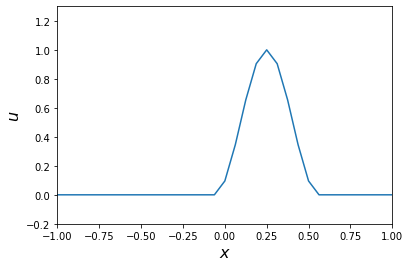

In [29]:
Nx = 33
Nt = 101

x = np.linspace(-1, 1, Nx)
t = np.linspace(0, 1, Nt)
u_init = np.array(np.zeros(len(x)))
u_init[15:25] = (-np.cos(2/(x[10]-x[0])*np.pi * (x[0:10]+1)) + 1)/2
#u_init = u_init+1
init = np.array(np.zeros((Nx, 3)))

bc = np.array(np.zeros((2*Nt, 3)))

n = 0
for i in [x[0], x[-1]]:
    for j in range(Nt):
        bc[n, 0] = i
        bc[n, 1] = t[j]
        n = n + 1

init[:, 0] = x
init[:, 2] = u_init

whole = np.array(np.zeros((Nx * Nt, 2)))

n = 0
for i in range(Nx):
    for j in range(Nt):
        whole[n, 0] = x[i]
        whole[n, 1] = t[j]
        n = n + 1

plt.plot(init[:, 0], init[:, 2])
plt.xlim(-1, 1)
plt.ylim(-0.2, 1.3)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$u$', fontsize=16)
plt.show()

In [34]:
# simulation

u_t = np.array(np.zeros((Nx, 1001)))

u_t[:, 0] = u_init


#Re = 100.0
dx = x[1] - x[0]
dt = (t[1] - t[0])/10

In [35]:

for n in range(0, 1000):   
    for i in range(1, Nx-1):
        u_t[i, n+1] = u_t[i, n] - 1 * dt / dx * (u_t[i, n] - u_t[i-1, n]) #+ 1/Re * dt/dx/dx*(u_t[i+1, n] - 2*u_t[i, n] + u_t[i-1, n]) #u_t[-1, n]

    u_t[-1, n+1] = u_t[-1, n] - 1 * dt / dx * (u_t[-1, n] - u_t[-1-1, n])# + 1/Re * dt/dx/dx*(u_t[-1+1, n] - 2*u_t[-1, n] + u_t[-1-1, n])
    u_t[0, n+1] = u_t[-1, n+1]
    

In [10]:
# create PINN network

layers = [2] + 3 * [20] + [1]
model = Convection_1D(init, whole, bc, layers)

In [11]:
# training
model.train(20000, 1e-4)

***************************************************************
Epoch: 0
***************************************************************
***************************************************************
Epoch: 1
***************************************************************
***************************************************************
Epoch: 2
***************************************************************
***************************************************************
Epoch: 3
***************************************************************
***************************************************************
Epoch: 4
***************************************************************
***************************************************************
Epoch: 5
***************************************************************
***************************************************************
Epoch: 6
***************************************************************
*****************************************

***************************************************************
Epoch: 62
***************************************************************
***************************************************************
Epoch: 63
***************************************************************
***************************************************************
Epoch: 64
***************************************************************
***************************************************************
Epoch: 65
***************************************************************
***************************************************************
Epoch: 66
***************************************************************
***************************************************************
Epoch: 67
***************************************************************
***************************************************************
Epoch: 68
***************************************************************
**********************************

***************************************************************
Epoch: 134
***************************************************************
***************************************************************
Epoch: 135
***************************************************************
***************************************************************
Epoch: 136
***************************************************************
***************************************************************
Epoch: 137
***************************************************************
***************************************************************
Epoch: 138
***************************************************************
***************************************************************
Epoch: 139
***************************************************************
***************************************************************
Epoch: 140
***************************************************************
***************************

***************************************************************
Epoch: 197
***************************************************************
***************************************************************
Epoch: 198
***************************************************************
***************************************************************
Epoch: 199
***************************************************************
***************************************************************
Epoch: 200
***************************************************************
***************************************************************
Epoch: 201
***************************************************************
***************************************************************
Epoch: 202
***************************************************************
***************************************************************
Epoch: 203
***************************************************************
***************************

***************************************************************
Epoch: 256
***************************************************************
***************************************************************
Epoch: 257
***************************************************************
***************************************************************
Epoch: 258
***************************************************************
***************************************************************
Epoch: 259
***************************************************************
***************************************************************
Epoch: 260
***************************************************************
***************************************************************
Epoch: 261
***************************************************************
***************************************************************
Epoch: 262
***************************************************************
***************************

***************************************************************
Epoch: 321
***************************************************************
***************************************************************
Epoch: 322
***************************************************************
***************************************************************
Epoch: 323
***************************************************************
***************************************************************
Epoch: 324
***************************************************************
***************************************************************
Epoch: 325
***************************************************************
***************************************************************
Epoch: 326
***************************************************************
***************************************************************
Epoch: 327
***************************************************************
***************************

***************************************************************
Epoch: 397
***************************************************************
***************************************************************
Epoch: 398
***************************************************************
***************************************************************
Epoch: 399
***************************************************************
***************************************************************
Epoch: 400
***************************************************************
***************************************************************
Epoch: 401
***************************************************************
***************************************************************
Epoch: 402
***************************************************************
***************************************************************
Epoch: 403
***************************************************************
***************************

***************************************************************
Epoch: 470
***************************************************************
***************************************************************
Epoch: 471
***************************************************************
***************************************************************
Epoch: 472
***************************************************************
***************************************************************
Epoch: 473
***************************************************************
***************************************************************
Epoch: 474
***************************************************************
***************************************************************
Epoch: 475
***************************************************************
***************************************************************
Epoch: 476
***************************************************************
***************************

***************************************************************
Epoch: 544
***************************************************************
***************************************************************
Epoch: 545
***************************************************************
***************************************************************
Epoch: 546
***************************************************************
***************************************************************
Epoch: 547
***************************************************************
***************************************************************
Epoch: 548
***************************************************************
***************************************************************
Epoch: 549
***************************************************************
***************************************************************
Epoch: 550
***************************************************************
***************************

***************************************************************
Epoch: 617
***************************************************************
***************************************************************
Epoch: 618
***************************************************************
***************************************************************
Epoch: 619
***************************************************************
***************************************************************
Epoch: 620
***************************************************************
***************************************************************
Epoch: 621
***************************************************************
***************************************************************
Epoch: 622
***************************************************************
***************************************************************
Epoch: 623
***************************************************************
***************************

***************************************************************
Epoch: 689
***************************************************************
***************************************************************
Epoch: 690
***************************************************************
***************************************************************
Epoch: 691
***************************************************************
***************************************************************
Epoch: 692
***************************************************************
***************************************************************
Epoch: 693
***************************************************************
***************************************************************
Epoch: 694
***************************************************************
***************************************************************
Epoch: 695
***************************************************************
***************************

***************************************************************
Epoch: 762
***************************************************************
***************************************************************
Epoch: 763
***************************************************************
***************************************************************
Epoch: 764
***************************************************************
***************************************************************
Epoch: 765
***************************************************************
***************************************************************
Epoch: 766
***************************************************************
***************************************************************
Epoch: 767
***************************************************************
***************************************************************
Epoch: 768
***************************************************************
***************************

***************************************************************
Epoch: 836
***************************************************************
***************************************************************
Epoch: 837
***************************************************************
***************************************************************
Epoch: 838
***************************************************************
***************************************************************
Epoch: 839
***************************************************************
***************************************************************
Epoch: 840
***************************************************************
***************************************************************
Epoch: 841
***************************************************************
***************************************************************
Epoch: 842
***************************************************************
***************************

***************************************************************
Epoch: 910
***************************************************************
***************************************************************
Epoch: 911
***************************************************************
***************************************************************
Epoch: 912
***************************************************************
***************************************************************
Epoch: 913
***************************************************************
***************************************************************
Epoch: 914
***************************************************************
***************************************************************
Epoch: 915
***************************************************************
***************************************************************
Epoch: 916
***************************************************************
***************************

***************************************************************
Epoch: 985
***************************************************************
***************************************************************
Epoch: 986
***************************************************************
***************************************************************
Epoch: 987
***************************************************************
***************************************************************
Epoch: 988
***************************************************************
***************************************************************
Epoch: 989
***************************************************************
***************************************************************
Epoch: 990
***************************************************************
***************************************************************
Epoch: 991
***************************************************************
***************************

***************************************************************
Epoch: 1059
***************************************************************
***************************************************************
Epoch: 1060
***************************************************************
***************************************************************
Epoch: 1061
***************************************************************
***************************************************************
Epoch: 1062
***************************************************************
***************************************************************
Epoch: 1063
***************************************************************
***************************************************************
Epoch: 1064
***************************************************************
***************************************************************
Epoch: 1065
***************************************************************
********************

***************************************************************
Epoch: 1134
***************************************************************
***************************************************************
Epoch: 1135
***************************************************************
***************************************************************
Epoch: 1136
***************************************************************
***************************************************************
Epoch: 1137
***************************************************************
***************************************************************
Epoch: 1138
***************************************************************
***************************************************************
Epoch: 1139
***************************************************************
***************************************************************
Epoch: 1140
***************************************************************
********************

***************************************************************
Epoch: 1206
***************************************************************
***************************************************************
Epoch: 1207
***************************************************************
***************************************************************
Epoch: 1208
***************************************************************
***************************************************************
Epoch: 1209
***************************************************************
***************************************************************
Epoch: 1210
***************************************************************
***************************************************************
Epoch: 1211
***************************************************************
***************************************************************
Epoch: 1212
***************************************************************
********************

***************************************************************
Epoch: 1282
***************************************************************
***************************************************************
Epoch: 1283
***************************************************************
***************************************************************
Epoch: 1284
***************************************************************
***************************************************************
Epoch: 1285
***************************************************************
***************************************************************
Epoch: 1286
***************************************************************
***************************************************************
Epoch: 1287
***************************************************************
***************************************************************
Epoch: 1288
***************************************************************
********************

***************************************************************
Epoch: 1356
***************************************************************
***************************************************************
Epoch: 1357
***************************************************************
***************************************************************
Epoch: 1358
***************************************************************
***************************************************************
Epoch: 1359
***************************************************************
***************************************************************
Epoch: 1360
***************************************************************
***************************************************************
Epoch: 1361
***************************************************************
***************************************************************
Epoch: 1362
***************************************************************
********************

***************************************************************
Epoch: 1431
***************************************************************
***************************************************************
Epoch: 1432
***************************************************************
***************************************************************
Epoch: 1433
***************************************************************
***************************************************************
Epoch: 1434
***************************************************************
***************************************************************
Epoch: 1435
***************************************************************
***************************************************************
Epoch: 1436
***************************************************************
***************************************************************
Epoch: 1437
***************************************************************
********************

***************************************************************
Epoch: 1506
***************************************************************
***************************************************************
Epoch: 1507
***************************************************************
***************************************************************
Epoch: 1508
***************************************************************
***************************************************************
Epoch: 1509
***************************************************************
***************************************************************
Epoch: 1510
***************************************************************
***************************************************************
Epoch: 1511
***************************************************************
***************************************************************
Epoch: 1512
***************************************************************
********************

***************************************************************
Epoch: 1580
***************************************************************
***************************************************************
Epoch: 1581
***************************************************************
***************************************************************
Epoch: 1582
***************************************************************
***************************************************************
Epoch: 1583
***************************************************************
***************************************************************
Epoch: 1584
***************************************************************
***************************************************************
Epoch: 1585
***************************************************************
***************************************************************
Epoch: 1586
***************************************************************
********************

***************************************************************
Epoch: 1654
***************************************************************
***************************************************************
Epoch: 1655
***************************************************************
***************************************************************
Epoch: 1656
***************************************************************
***************************************************************
Epoch: 1657
***************************************************************
***************************************************************
Epoch: 1658
***************************************************************
***************************************************************
Epoch: 1659
***************************************************************
***************************************************************
Epoch: 1660
***************************************************************
********************

***************************************************************
Epoch: 1728
***************************************************************
***************************************************************
Epoch: 1729
***************************************************************
***************************************************************
Epoch: 1730
***************************************************************
***************************************************************
Epoch: 1731
***************************************************************
***************************************************************
Epoch: 1732
***************************************************************
***************************************************************
Epoch: 1733
***************************************************************
***************************************************************
Epoch: 1734
***************************************************************
********************

***************************************************************
Epoch: 1802
***************************************************************
***************************************************************
Epoch: 1803
***************************************************************
***************************************************************
Epoch: 1804
***************************************************************
***************************************************************
Epoch: 1805
***************************************************************
***************************************************************
Epoch: 1806
***************************************************************
***************************************************************
Epoch: 1807
***************************************************************
***************************************************************
Epoch: 1808
***************************************************************
********************

***************************************************************
Epoch: 1875
***************************************************************
***************************************************************
Epoch: 1876
***************************************************************
***************************************************************
Epoch: 1877
***************************************************************
***************************************************************
Epoch: 1878
***************************************************************
***************************************************************
Epoch: 1879
***************************************************************
***************************************************************
Epoch: 1880
***************************************************************
***************************************************************
Epoch: 1881
***************************************************************
********************

***************************************************************
Epoch: 1950
***************************************************************
***************************************************************
Epoch: 1951
***************************************************************
***************************************************************
Epoch: 1952
***************************************************************
***************************************************************
Epoch: 1953
***************************************************************
***************************************************************
Epoch: 1954
***************************************************************
***************************************************************
Epoch: 1955
***************************************************************
***************************************************************
Epoch: 1956
***************************************************************
********************

***************************************************************
Epoch: 2025
***************************************************************
***************************************************************
Epoch: 2026
***************************************************************
***************************************************************
Epoch: 2027
***************************************************************
***************************************************************
Epoch: 2028
***************************************************************
***************************************************************
Epoch: 2029
***************************************************************
***************************************************************
Epoch: 2030
***************************************************************
***************************************************************
Epoch: 2031
***************************************************************
********************

***************************************************************
Epoch: 2098
***************************************************************
***************************************************************
Epoch: 2099
***************************************************************
***************************************************************
Epoch: 2100
***************************************************************
***************************************************************
Epoch: 2101
***************************************************************
***************************************************************
Epoch: 2102
***************************************************************
***************************************************************
Epoch: 2103
***************************************************************
***************************************************************
Epoch: 2104
***************************************************************
********************

***************************************************************
Epoch: 2173
***************************************************************
***************************************************************
Epoch: 2174
***************************************************************
***************************************************************
Epoch: 2175
***************************************************************
***************************************************************
Epoch: 2176
***************************************************************
***************************************************************
Epoch: 2177
***************************************************************
***************************************************************
Epoch: 2178
***************************************************************
***************************************************************
Epoch: 2179
***************************************************************
********************

***************************************************************
Epoch: 2246
***************************************************************
***************************************************************
Epoch: 2247
***************************************************************
***************************************************************
Epoch: 2248
***************************************************************
***************************************************************
Epoch: 2249
***************************************************************
***************************************************************
Epoch: 2250
***************************************************************
***************************************************************
Epoch: 2251
***************************************************************
***************************************************************
Epoch: 2252
***************************************************************
********************

***************************************************************
Epoch: 2319
***************************************************************
***************************************************************
Epoch: 2320
***************************************************************
***************************************************************
Epoch: 2321
***************************************************************
***************************************************************
Epoch: 2322
***************************************************************
***************************************************************
Epoch: 2323
***************************************************************
***************************************************************
Epoch: 2324
***************************************************************
***************************************************************
Epoch: 2325
***************************************************************
********************

***************************************************************
Epoch: 2383
***************************************************************
***************************************************************
Epoch: 2384
***************************************************************
***************************************************************
Epoch: 2385
***************************************************************
***************************************************************
Epoch: 2386
***************************************************************
***************************************************************
Epoch: 2387
***************************************************************
***************************************************************
Epoch: 2388
***************************************************************
***************************************************************
Epoch: 2389
***************************************************************
********************

***************************************************************
Epoch: 2444
***************************************************************
***************************************************************
Epoch: 2445
***************************************************************
***************************************************************
Epoch: 2446
***************************************************************
***************************************************************
Epoch: 2447
***************************************************************
***************************************************************
Epoch: 2448
***************************************************************
***************************************************************
Epoch: 2449
***************************************************************
***************************************************************
Epoch: 2450
***************************************************************
********************

***************************************************************
Epoch: 2516
***************************************************************
***************************************************************
Epoch: 2517
***************************************************************
***************************************************************
Epoch: 2518
***************************************************************
***************************************************************
Epoch: 2519
***************************************************************
***************************************************************
Epoch: 2520
***************************************************************
***************************************************************
Epoch: 2521
***************************************************************
***************************************************************
Epoch: 2522
***************************************************************
********************

***************************************************************
Epoch: 2587
***************************************************************
***************************************************************
Epoch: 2588
***************************************************************
***************************************************************
Epoch: 2589
***************************************************************
***************************************************************
Epoch: 2590
***************************************************************
***************************************************************
Epoch: 2591
***************************************************************
***************************************************************
Epoch: 2592
***************************************************************
***************************************************************
Epoch: 2593
***************************************************************
********************

***************************************************************
Epoch: 2653
***************************************************************
***************************************************************
Epoch: 2654
***************************************************************
***************************************************************
Epoch: 2655
***************************************************************
***************************************************************
Epoch: 2656
***************************************************************
***************************************************************
Epoch: 2657
***************************************************************
***************************************************************
Epoch: 2658
***************************************************************
***************************************************************
Epoch: 2659
***************************************************************
********************

***************************************************************
Epoch: 2714
***************************************************************
***************************************************************
Epoch: 2715
***************************************************************
***************************************************************
Epoch: 2716
***************************************************************
***************************************************************
Epoch: 2717
***************************************************************
***************************************************************
Epoch: 2718
***************************************************************
***************************************************************
Epoch: 2719
***************************************************************
***************************************************************
Epoch: 2720
***************************************************************
********************

***************************************************************
Epoch: 2783
***************************************************************
***************************************************************
Epoch: 2784
***************************************************************
***************************************************************
Epoch: 2785
***************************************************************
***************************************************************
Epoch: 2786
***************************************************************
***************************************************************
Epoch: 2787
***************************************************************
***************************************************************
Epoch: 2788
***************************************************************
***************************************************************
Epoch: 2789
***************************************************************
********************

***************************************************************
Epoch: 2844
***************************************************************
***************************************************************
Epoch: 2845
***************************************************************
***************************************************************
Epoch: 2846
***************************************************************
***************************************************************
Epoch: 2847
***************************************************************
***************************************************************
Epoch: 2848
***************************************************************
***************************************************************
Epoch: 2849
***************************************************************
***************************************************************
Epoch: 2850
***************************************************************
********************

***************************************************************
Epoch: 2909
***************************************************************
***************************************************************
Epoch: 2910
***************************************************************
***************************************************************
Epoch: 2911
***************************************************************
***************************************************************
Epoch: 2912
***************************************************************
***************************************************************
Epoch: 2913
***************************************************************
***************************************************************
Epoch: 2914
***************************************************************
***************************************************************
Epoch: 2915
***************************************************************
********************

***************************************************************
Epoch: 2976
***************************************************************
***************************************************************
Epoch: 2977
***************************************************************
***************************************************************
Epoch: 2978
***************************************************************
***************************************************************
Epoch: 2979
***************************************************************
***************************************************************
Epoch: 2980
***************************************************************
***************************************************************
Epoch: 2981
***************************************************************
***************************************************************
Epoch: 2982
***************************************************************
********************

***************************************************************
Epoch: 3043
***************************************************************
***************************************************************
Epoch: 3044
***************************************************************
***************************************************************
Epoch: 3045
***************************************************************
***************************************************************
Epoch: 3046
***************************************************************
***************************************************************
Epoch: 3047
***************************************************************
***************************************************************
Epoch: 3048
***************************************************************
***************************************************************
Epoch: 3049
***************************************************************
********************

***************************************************************
Epoch: 3106
***************************************************************
***************************************************************
Epoch: 3107
***************************************************************
***************************************************************
Epoch: 3108
***************************************************************
***************************************************************
Epoch: 3109
***************************************************************
***************************************************************
Epoch: 3110
***************************************************************
***************************************************************
Epoch: 3111
***************************************************************
***************************************************************
Epoch: 3112
***************************************************************
********************

***************************************************************
Epoch: 3171
***************************************************************
***************************************************************
Epoch: 3172
***************************************************************
***************************************************************
Epoch: 3173
***************************************************************
***************************************************************
Epoch: 3174
***************************************************************
***************************************************************
Epoch: 3175
***************************************************************
***************************************************************
Epoch: 3176
***************************************************************
***************************************************************
Epoch: 3177
***************************************************************
********************

***************************************************************
Epoch: 3233
***************************************************************
***************************************************************
Epoch: 3234
***************************************************************
***************************************************************
Epoch: 3235
***************************************************************
***************************************************************
Epoch: 3236
***************************************************************
***************************************************************
Epoch: 3237
***************************************************************
***************************************************************
Epoch: 3238
***************************************************************
***************************************************************
Epoch: 3239
***************************************************************
********************

***************************************************************
Epoch: 3293
***************************************************************
***************************************************************
Epoch: 3294
***************************************************************
***************************************************************
Epoch: 3295
***************************************************************
***************************************************************
Epoch: 3296
***************************************************************
***************************************************************
Epoch: 3297
***************************************************************
***************************************************************
Epoch: 3298
***************************************************************
***************************************************************
Epoch: 3299
***************************************************************
********************

***************************************************************
Epoch: 3352
***************************************************************
***************************************************************
Epoch: 3353
***************************************************************
***************************************************************
Epoch: 3354
***************************************************************
***************************************************************
Epoch: 3355
***************************************************************
***************************************************************
Epoch: 3356
***************************************************************
***************************************************************
Epoch: 3357
***************************************************************
***************************************************************
Epoch: 3358
***************************************************************
********************

***************************************************************
Epoch: 3411
***************************************************************
***************************************************************
Epoch: 3412
***************************************************************
***************************************************************
Epoch: 3413
***************************************************************
***************************************************************
Epoch: 3414
***************************************************************
***************************************************************
Epoch: 3415
***************************************************************
***************************************************************
Epoch: 3416
***************************************************************
***************************************************************
Epoch: 3417
***************************************************************
********************

***************************************************************
Epoch: 3477
***************************************************************
***************************************************************
Epoch: 3478
***************************************************************
***************************************************************
Epoch: 3479
***************************************************************
***************************************************************
Epoch: 3480
***************************************************************
***************************************************************
Epoch: 3481
***************************************************************
***************************************************************
Epoch: 3482
***************************************************************
***************************************************************
Epoch: 3483
***************************************************************
********************

***************************************************************
Epoch: 3544
***************************************************************
***************************************************************
Epoch: 3545
***************************************************************
***************************************************************
Epoch: 3546
***************************************************************
***************************************************************
Epoch: 3547
***************************************************************
***************************************************************
Epoch: 3548
***************************************************************
***************************************************************
Epoch: 3549
***************************************************************
***************************************************************
Epoch: 3550
***************************************************************
********************

***************************************************************
Epoch: 3612
***************************************************************
***************************************************************
Epoch: 3613
***************************************************************
***************************************************************
Epoch: 3614
***************************************************************
***************************************************************
Epoch: 3615
***************************************************************
***************************************************************
Epoch: 3616
***************************************************************
***************************************************************
Epoch: 3617
***************************************************************
***************************************************************
Epoch: 3618
***************************************************************
********************

***************************************************************
Epoch: 3683
***************************************************************
***************************************************************
Epoch: 3684
***************************************************************
***************************************************************
Epoch: 3685
***************************************************************
***************************************************************
Epoch: 3686
***************************************************************
***************************************************************
Epoch: 3687
***************************************************************
***************************************************************
Epoch: 3688
***************************************************************
***************************************************************
Epoch: 3689
***************************************************************
********************

***************************************************************
Epoch: 3750
***************************************************************
***************************************************************
Epoch: 3751
***************************************************************
***************************************************************
Epoch: 3752
***************************************************************
***************************************************************
Epoch: 3753
***************************************************************
***************************************************************
Epoch: 3754
***************************************************************
***************************************************************
Epoch: 3755
***************************************************************
***************************************************************
Epoch: 3756
***************************************************************
********************

***************************************************************
Epoch: 3814
***************************************************************
***************************************************************
Epoch: 3815
***************************************************************
***************************************************************
Epoch: 3816
***************************************************************
***************************************************************
Epoch: 3817
***************************************************************
***************************************************************
Epoch: 3818
***************************************************************
***************************************************************
Epoch: 3819
***************************************************************
***************************************************************
Epoch: 3820
***************************************************************
********************

***************************************************************
Epoch: 3879
***************************************************************
***************************************************************
Epoch: 3880
***************************************************************
***************************************************************
Epoch: 3881
***************************************************************
***************************************************************
Epoch: 3882
***************************************************************
***************************************************************
Epoch: 3883
***************************************************************
***************************************************************
Epoch: 3884
***************************************************************
***************************************************************
Epoch: 3885
***************************************************************
********************

***************************************************************
Epoch: 3939
***************************************************************
***************************************************************
Epoch: 3940
***************************************************************
***************************************************************
Epoch: 3941
***************************************************************
***************************************************************
Epoch: 3942
***************************************************************
***************************************************************
Epoch: 3943
***************************************************************
***************************************************************
Epoch: 3944
***************************************************************
***************************************************************
Epoch: 3945
***************************************************************
********************

***************************************************************
Epoch: 4007
***************************************************************
***************************************************************
Epoch: 4008
***************************************************************
***************************************************************
Epoch: 4009
***************************************************************
***************************************************************
Epoch: 4010
***************************************************************
***************************************************************
Epoch: 4011
***************************************************************
***************************************************************
Epoch: 4012
***************************************************************
***************************************************************
Epoch: 4013
***************************************************************
********************

***************************************************************
Epoch: 4079
***************************************************************
***************************************************************
Epoch: 4080
***************************************************************
***************************************************************
Epoch: 4081
***************************************************************
***************************************************************
Epoch: 4082
***************************************************************
***************************************************************
Epoch: 4083
***************************************************************
***************************************************************
Epoch: 4084
***************************************************************
***************************************************************
Epoch: 4085
***************************************************************
********************

***************************************************************
Epoch: 4147
***************************************************************
***************************************************************
Epoch: 4148
***************************************************************
***************************************************************
Epoch: 4149
***************************************************************
***************************************************************
Epoch: 4150
***************************************************************
***************************************************************
Epoch: 4151
***************************************************************
***************************************************************
Epoch: 4152
***************************************************************
***************************************************************
Epoch: 4153
***************************************************************
********************

***************************************************************
Epoch: 4219
***************************************************************
***************************************************************
Epoch: 4220
***************************************************************
***************************************************************
Epoch: 4221
***************************************************************
***************************************************************
Epoch: 4222
***************************************************************
***************************************************************
Epoch: 4223
***************************************************************
***************************************************************
Epoch: 4224
***************************************************************
***************************************************************
Epoch: 4225
***************************************************************
********************

***************************************************************
Epoch: 4295
***************************************************************
***************************************************************
Epoch: 4296
***************************************************************
***************************************************************
Epoch: 4297
***************************************************************
***************************************************************
Epoch: 4298
***************************************************************
***************************************************************
Epoch: 4299
***************************************************************
***************************************************************
Epoch: 4300
***************************************************************
***************************************************************
Epoch: 4301
***************************************************************
********************

***************************************************************
Epoch: 4370
***************************************************************
***************************************************************
Epoch: 4371
***************************************************************
***************************************************************
Epoch: 4372
***************************************************************
***************************************************************
Epoch: 4373
***************************************************************
***************************************************************
Epoch: 4374
***************************************************************
***************************************************************
Epoch: 4375
***************************************************************
***************************************************************
Epoch: 4376
***************************************************************
********************

***************************************************************
Epoch: 4444
***************************************************************
***************************************************************
Epoch: 4445
***************************************************************
***************************************************************
Epoch: 4446
***************************************************************
***************************************************************
Epoch: 4447
***************************************************************
***************************************************************
Epoch: 4448
***************************************************************
***************************************************************
Epoch: 4449
***************************************************************
***************************************************************
Epoch: 4450
***************************************************************
********************

***************************************************************
Epoch: 4520
***************************************************************
***************************************************************
Epoch: 4521
***************************************************************
***************************************************************
Epoch: 4522
***************************************************************
***************************************************************
Epoch: 4523
***************************************************************
***************************************************************
Epoch: 4524
***************************************************************
***************************************************************
Epoch: 4525
***************************************************************
***************************************************************
Epoch: 4526
***************************************************************
********************

***************************************************************
Epoch: 4592
***************************************************************
***************************************************************
Epoch: 4593
***************************************************************
***************************************************************
Epoch: 4594
***************************************************************
***************************************************************
Epoch: 4595
***************************************************************
***************************************************************
Epoch: 4596
***************************************************************
***************************************************************
Epoch: 4597
***************************************************************
***************************************************************
Epoch: 4598
***************************************************************
********************

***************************************************************
Epoch: 4667
***************************************************************
***************************************************************
Epoch: 4668
***************************************************************
***************************************************************
Epoch: 4669
***************************************************************
***************************************************************
Epoch: 4670
***************************************************************
***************************************************************
Epoch: 4671
***************************************************************
***************************************************************
Epoch: 4672
***************************************************************
***************************************************************
Epoch: 4673
***************************************************************
********************

***************************************************************
Epoch: 4740
***************************************************************
***************************************************************
Epoch: 4741
***************************************************************
***************************************************************
Epoch: 4742
***************************************************************
***************************************************************
Epoch: 4743
***************************************************************
***************************************************************
Epoch: 4744
***************************************************************
***************************************************************
Epoch: 4745
***************************************************************
***************************************************************
Epoch: 4746
***************************************************************
********************

***************************************************************
Epoch: 4816
***************************************************************
***************************************************************
Epoch: 4817
***************************************************************
***************************************************************
Epoch: 4818
***************************************************************
***************************************************************
Epoch: 4819
***************************************************************
***************************************************************
Epoch: 4820
***************************************************************
***************************************************************
Epoch: 4821
***************************************************************
***************************************************************
Epoch: 4822
***************************************************************
********************

***************************************************************
Epoch: 4887
***************************************************************
***************************************************************
Epoch: 4888
***************************************************************
***************************************************************
Epoch: 4889
***************************************************************
***************************************************************
Epoch: 4890
***************************************************************
***************************************************************
Epoch: 4891
***************************************************************
***************************************************************
Epoch: 4892
***************************************************************
***************************************************************
Epoch: 4893
***************************************************************
********************

***************************************************************
Epoch: 4963
***************************************************************
***************************************************************
Epoch: 4964
***************************************************************
***************************************************************
Epoch: 4965
***************************************************************
***************************************************************
Epoch: 4966
***************************************************************
***************************************************************
Epoch: 4967
***************************************************************
***************************************************************
Epoch: 4968
***************************************************************
***************************************************************
Epoch: 4969
***************************************************************
********************

***************************************************************
Epoch: 5038
***************************************************************
***************************************************************
Epoch: 5039
***************************************************************
***************************************************************
Epoch: 5040
***************************************************************
***************************************************************
Epoch: 5041
***************************************************************
***************************************************************
Epoch: 5042
***************************************************************
***************************************************************
Epoch: 5043
***************************************************************
***************************************************************
Epoch: 5044
***************************************************************
********************

***************************************************************
Epoch: 5113
***************************************************************
***************************************************************
Epoch: 5114
***************************************************************
***************************************************************
Epoch: 5115
***************************************************************
***************************************************************
Epoch: 5116
***************************************************************
***************************************************************
Epoch: 5117
***************************************************************
***************************************************************
Epoch: 5118
***************************************************************
***************************************************************
Epoch: 5119
***************************************************************
********************

***************************************************************
Epoch: 5189
***************************************************************
***************************************************************
Epoch: 5190
***************************************************************
***************************************************************
Epoch: 5191
***************************************************************
***************************************************************
Epoch: 5192
***************************************************************
***************************************************************
Epoch: 5193
***************************************************************
***************************************************************
Epoch: 5194
***************************************************************
***************************************************************
Epoch: 5195
***************************************************************
********************

***************************************************************
Epoch: 5264
***************************************************************
***************************************************************
Epoch: 5265
***************************************************************
***************************************************************
Epoch: 5266
***************************************************************
***************************************************************
Epoch: 5267
***************************************************************
***************************************************************
Epoch: 5268
***************************************************************
***************************************************************
Epoch: 5269
***************************************************************
***************************************************************
Epoch: 5270
***************************************************************
********************

***************************************************************
Epoch: 5336
***************************************************************
***************************************************************
Epoch: 5337
***************************************************************
***************************************************************
Epoch: 5338
***************************************************************
***************************************************************
Epoch: 5339
***************************************************************
***************************************************************
Epoch: 5340
***************************************************************
***************************************************************
Epoch: 5341
***************************************************************
***************************************************************
Epoch: 5342
***************************************************************
********************

***************************************************************
Epoch: 5406
***************************************************************
***************************************************************
Epoch: 5407
***************************************************************
***************************************************************
Epoch: 5408
***************************************************************
***************************************************************
Epoch: 5409
***************************************************************
***************************************************************
Epoch: 5410
***************************************************************
***************************************************************
Epoch: 5411
***************************************************************
***************************************************************
Epoch: 5412
***************************************************************
********************

***************************************************************
Epoch: 5471
***************************************************************
***************************************************************
Epoch: 5472
***************************************************************
***************************************************************
Epoch: 5473
***************************************************************
***************************************************************
Epoch: 5474
***************************************************************
***************************************************************
Epoch: 5475
***************************************************************
***************************************************************
Epoch: 5476
***************************************************************
***************************************************************
Epoch: 5477
***************************************************************
********************

***************************************************************
Epoch: 5541
***************************************************************
***************************************************************
Epoch: 5542
***************************************************************
***************************************************************
Epoch: 5543
***************************************************************
***************************************************************
Epoch: 5544
***************************************************************
***************************************************************
Epoch: 5545
***************************************************************
***************************************************************
Epoch: 5546
***************************************************************
***************************************************************
Epoch: 5547
***************************************************************
********************

***************************************************************
Epoch: 5611
***************************************************************
***************************************************************
Epoch: 5612
***************************************************************
***************************************************************
Epoch: 5613
***************************************************************
***************************************************************
Epoch: 5614
***************************************************************
***************************************************************
Epoch: 5615
***************************************************************
***************************************************************
Epoch: 5616
***************************************************************
***************************************************************
Epoch: 5617
***************************************************************
********************

***************************************************************
Epoch: 5687
***************************************************************
***************************************************************
Epoch: 5688
***************************************************************
***************************************************************
Epoch: 5689
***************************************************************
***************************************************************
Epoch: 5690
***************************************************************
***************************************************************
Epoch: 5691
***************************************************************
***************************************************************
Epoch: 5692
***************************************************************
***************************************************************
Epoch: 5693
***************************************************************
********************

***************************************************************
Epoch: 5762
***************************************************************
***************************************************************
Epoch: 5763
***************************************************************
***************************************************************
Epoch: 5764
***************************************************************
***************************************************************
Epoch: 5765
***************************************************************
***************************************************************
Epoch: 5766
***************************************************************
***************************************************************
Epoch: 5767
***************************************************************
***************************************************************
Epoch: 5768
***************************************************************
********************

***************************************************************
Epoch: 5835
***************************************************************
***************************************************************
Epoch: 5836
***************************************************************
***************************************************************
Epoch: 5837
***************************************************************
***************************************************************
Epoch: 5838
***************************************************************
***************************************************************
Epoch: 5839
***************************************************************
***************************************************************
Epoch: 5840
***************************************************************
***************************************************************
Epoch: 5841
***************************************************************
********************

***************************************************************
Epoch: 5897
***************************************************************
***************************************************************
Epoch: 5898
***************************************************************
***************************************************************
Epoch: 5899
***************************************************************
***************************************************************
Epoch: 5900
***************************************************************
***************************************************************
Epoch: 5901
***************************************************************
***************************************************************
Epoch: 5902
***************************************************************
***************************************************************
Epoch: 5903
***************************************************************
********************

***************************************************************
Epoch: 5956
***************************************************************
***************************************************************
Epoch: 5957
***************************************************************
***************************************************************
Epoch: 5958
***************************************************************
***************************************************************
Epoch: 5959
***************************************************************
***************************************************************
Epoch: 5960
***************************************************************
***************************************************************
Epoch: 5961
***************************************************************
***************************************************************
Epoch: 5962
***************************************************************
********************

***************************************************************
Epoch: 6030
***************************************************************
***************************************************************
Epoch: 6031
***************************************************************
***************************************************************
Epoch: 6032
***************************************************************
***************************************************************
Epoch: 6033
***************************************************************
***************************************************************
Epoch: 6034
***************************************************************
***************************************************************
Epoch: 6035
***************************************************************
***************************************************************
Epoch: 6036
***************************************************************
********************

***************************************************************
Epoch: 6100
***************************************************************
***************************************************************
Epoch: 6101
***************************************************************
***************************************************************
Epoch: 6102
***************************************************************
***************************************************************
Epoch: 6103
***************************************************************
***************************************************************
Epoch: 6104
***************************************************************
***************************************************************
Epoch: 6105
***************************************************************
***************************************************************
Epoch: 6106
***************************************************************
********************

***************************************************************
Epoch: 6174
***************************************************************
***************************************************************
Epoch: 6175
***************************************************************
***************************************************************
Epoch: 6176
***************************************************************
***************************************************************
Epoch: 6177
***************************************************************
***************************************************************
Epoch: 6178
***************************************************************
***************************************************************
Epoch: 6179
***************************************************************
***************************************************************
Epoch: 6180
***************************************************************
********************

***************************************************************
Epoch: 6247
***************************************************************
***************************************************************
Epoch: 6248
***************************************************************
***************************************************************
Epoch: 6249
***************************************************************
***************************************************************
Epoch: 6250
***************************************************************
***************************************************************
Epoch: 6251
***************************************************************
***************************************************************
Epoch: 6252
***************************************************************
***************************************************************
Epoch: 6253
***************************************************************
********************

***************************************************************
Epoch: 6322
***************************************************************
***************************************************************
Epoch: 6323
***************************************************************
***************************************************************
Epoch: 6324
***************************************************************
***************************************************************
Epoch: 6325
***************************************************************
***************************************************************
Epoch: 6326
***************************************************************
***************************************************************
Epoch: 6327
***************************************************************
***************************************************************
Epoch: 6328
***************************************************************
********************

***************************************************************
Epoch: 6396
***************************************************************
***************************************************************
Epoch: 6397
***************************************************************
***************************************************************
Epoch: 6398
***************************************************************
***************************************************************
Epoch: 6399
***************************************************************
***************************************************************
Epoch: 6400
***************************************************************
***************************************************************
Epoch: 6401
***************************************************************
***************************************************************
Epoch: 6402
***************************************************************
********************

***************************************************************
Epoch: 6471
***************************************************************
***************************************************************
Epoch: 6472
***************************************************************
***************************************************************
Epoch: 6473
***************************************************************
***************************************************************
Epoch: 6474
***************************************************************
***************************************************************
Epoch: 6475
***************************************************************
***************************************************************
Epoch: 6476
***************************************************************
***************************************************************
Epoch: 6477
***************************************************************
********************

***************************************************************
Epoch: 6545
***************************************************************
***************************************************************
Epoch: 6546
***************************************************************
***************************************************************
Epoch: 6547
***************************************************************
***************************************************************
Epoch: 6548
***************************************************************
***************************************************************
Epoch: 6549
***************************************************************
***************************************************************
Epoch: 6550
***************************************************************
***************************************************************
Epoch: 6551
***************************************************************
********************

***************************************************************
Epoch: 6619
***************************************************************
***************************************************************
Epoch: 6620
***************************************************************
***************************************************************
Epoch: 6621
***************************************************************
***************************************************************
Epoch: 6622
***************************************************************
***************************************************************
Epoch: 6623
***************************************************************
***************************************************************
Epoch: 6624
***************************************************************
***************************************************************
Epoch: 6625
***************************************************************
********************

***************************************************************
Epoch: 6691
***************************************************************
***************************************************************
Epoch: 6692
***************************************************************
***************************************************************
Epoch: 6693
***************************************************************
***************************************************************
Epoch: 6694
***************************************************************
***************************************************************
Epoch: 6695
***************************************************************
***************************************************************
Epoch: 6696
***************************************************************
***************************************************************
Epoch: 6697
***************************************************************
********************

***************************************************************
Epoch: 6767
***************************************************************
***************************************************************
Epoch: 6768
***************************************************************
***************************************************************
Epoch: 6769
***************************************************************
***************************************************************
Epoch: 6770
***************************************************************
***************************************************************
Epoch: 6771
***************************************************************
***************************************************************
Epoch: 6772
***************************************************************
***************************************************************
Epoch: 6773
***************************************************************
********************

***************************************************************
Epoch: 6841
***************************************************************
***************************************************************
Epoch: 6842
***************************************************************
***************************************************************
Epoch: 6843
***************************************************************
***************************************************************
Epoch: 6844
***************************************************************
***************************************************************
Epoch: 6845
***************************************************************
***************************************************************
Epoch: 6846
***************************************************************
***************************************************************
Epoch: 6847
***************************************************************
********************

***************************************************************
Epoch: 6914
***************************************************************
***************************************************************
Epoch: 6915
***************************************************************
***************************************************************
Epoch: 6916
***************************************************************
***************************************************************
Epoch: 6917
***************************************************************
***************************************************************
Epoch: 6918
***************************************************************
***************************************************************
Epoch: 6919
***************************************************************
***************************************************************
Epoch: 6920
***************************************************************
********************

***************************************************************
Epoch: 6987
***************************************************************
***************************************************************
Epoch: 6988
***************************************************************
***************************************************************
Epoch: 6989
***************************************************************
***************************************************************
Epoch: 6990
***************************************************************
***************************************************************
Epoch: 6991
***************************************************************
***************************************************************
Epoch: 6992
***************************************************************
***************************************************************
Epoch: 6993
***************************************************************
********************

***************************************************************
Epoch: 7063
***************************************************************
***************************************************************
Epoch: 7064
***************************************************************
***************************************************************
Epoch: 7065
***************************************************************
***************************************************************
Epoch: 7066
***************************************************************
***************************************************************
Epoch: 7067
***************************************************************
***************************************************************
Epoch: 7068
***************************************************************
***************************************************************
Epoch: 7069
***************************************************************
********************

***************************************************************
Epoch: 7138
***************************************************************
***************************************************************
Epoch: 7139
***************************************************************
***************************************************************
Epoch: 7140
***************************************************************
***************************************************************
Epoch: 7141
***************************************************************
***************************************************************
Epoch: 7142
***************************************************************
***************************************************************
Epoch: 7143
***************************************************************
***************************************************************
Epoch: 7144
***************************************************************
********************

***************************************************************
Epoch: 7211
***************************************************************
***************************************************************
Epoch: 7212
***************************************************************
***************************************************************
Epoch: 7213
***************************************************************
***************************************************************
Epoch: 7214
***************************************************************
***************************************************************
Epoch: 7215
***************************************************************
***************************************************************
Epoch: 7216
***************************************************************
***************************************************************
Epoch: 7217
***************************************************************
********************

***************************************************************
Epoch: 7284
***************************************************************
***************************************************************
Epoch: 7285
***************************************************************
***************************************************************
Epoch: 7286
***************************************************************
***************************************************************
Epoch: 7287
***************************************************************
***************************************************************
Epoch: 7288
***************************************************************
***************************************************************
Epoch: 7289
***************************************************************
***************************************************************
Epoch: 7290
***************************************************************
********************

***************************************************************
Epoch: 7357
***************************************************************
***************************************************************
Epoch: 7358
***************************************************************
***************************************************************
Epoch: 7359
***************************************************************
***************************************************************
Epoch: 7360
***************************************************************
***************************************************************
Epoch: 7361
***************************************************************
***************************************************************
Epoch: 7362
***************************************************************
***************************************************************
Epoch: 7363
***************************************************************
********************

***************************************************************
Epoch: 7430
***************************************************************
***************************************************************
Epoch: 7431
***************************************************************
***************************************************************
Epoch: 7432
***************************************************************
***************************************************************
Epoch: 7433
***************************************************************
***************************************************************
Epoch: 7434
***************************************************************
***************************************************************
Epoch: 7435
***************************************************************
***************************************************************
Epoch: 7436
***************************************************************
********************

***************************************************************
Epoch: 7503
***************************************************************
***************************************************************
Epoch: 7504
***************************************************************
***************************************************************
Epoch: 7505
***************************************************************
***************************************************************
Epoch: 7506
***************************************************************
***************************************************************
Epoch: 7507
***************************************************************
***************************************************************
Epoch: 7508
***************************************************************
***************************************************************
Epoch: 7509
***************************************************************
********************

***************************************************************
Epoch: 7577
***************************************************************
***************************************************************
Epoch: 7578
***************************************************************
***************************************************************
Epoch: 7579
***************************************************************
***************************************************************
Epoch: 7580
***************************************************************
***************************************************************
Epoch: 7581
***************************************************************
***************************************************************
Epoch: 7582
***************************************************************
***************************************************************
Epoch: 7583
***************************************************************
********************

***************************************************************
Epoch: 7650
***************************************************************
***************************************************************
Epoch: 7651
***************************************************************
***************************************************************
Epoch: 7652
***************************************************************
***************************************************************
Epoch: 7653
***************************************************************
***************************************************************
Epoch: 7654
***************************************************************
***************************************************************
Epoch: 7655
***************************************************************
***************************************************************
Epoch: 7656
***************************************************************
********************

***************************************************************
Epoch: 7723
***************************************************************
***************************************************************
Epoch: 7724
***************************************************************
***************************************************************
Epoch: 7725
***************************************************************
***************************************************************
Epoch: 7726
***************************************************************
***************************************************************
Epoch: 7727
***************************************************************
***************************************************************
Epoch: 7728
***************************************************************
***************************************************************
Epoch: 7729
***************************************************************
********************

***************************************************************
Epoch: 7794
***************************************************************
***************************************************************
Epoch: 7795
***************************************************************
***************************************************************
Epoch: 7796
***************************************************************
***************************************************************
Epoch: 7797
***************************************************************
***************************************************************
Epoch: 7798
***************************************************************
***************************************************************
Epoch: 7799
***************************************************************
***************************************************************
Epoch: 7800
***************************************************************
********************

***************************************************************
Epoch: 7866
***************************************************************
***************************************************************
Epoch: 7867
***************************************************************
***************************************************************
Epoch: 7868
***************************************************************
***************************************************************
Epoch: 7869
***************************************************************
***************************************************************
Epoch: 7870
***************************************************************
***************************************************************
Epoch: 7871
***************************************************************
***************************************************************
Epoch: 7872
***************************************************************
********************

***************************************************************
Epoch: 7940
***************************************************************
***************************************************************
Epoch: 7941
***************************************************************
***************************************************************
Epoch: 7942
***************************************************************
***************************************************************
Epoch: 7943
***************************************************************
***************************************************************
Epoch: 7944
***************************************************************
***************************************************************
Epoch: 7945
***************************************************************
***************************************************************
Epoch: 7946
***************************************************************
********************

***************************************************************
Epoch: 8011
***************************************************************
***************************************************************
Epoch: 8012
***************************************************************
***************************************************************
Epoch: 8013
***************************************************************
***************************************************************
Epoch: 8014
***************************************************************
***************************************************************
Epoch: 8015
***************************************************************
***************************************************************
Epoch: 8016
***************************************************************
***************************************************************
Epoch: 8017
***************************************************************
********************

***************************************************************
Epoch: 8085
***************************************************************
***************************************************************
Epoch: 8086
***************************************************************
***************************************************************
Epoch: 8087
***************************************************************
***************************************************************
Epoch: 8088
***************************************************************
***************************************************************
Epoch: 8089
***************************************************************
***************************************************************
Epoch: 8090
***************************************************************
***************************************************************
Epoch: 8091
***************************************************************
********************

***************************************************************
Epoch: 8160
***************************************************************
***************************************************************
Epoch: 8161
***************************************************************
***************************************************************
Epoch: 8162
***************************************************************
***************************************************************
Epoch: 8163
***************************************************************
***************************************************************
Epoch: 8164
***************************************************************
***************************************************************
Epoch: 8165
***************************************************************
***************************************************************
Epoch: 8166
***************************************************************
********************

***************************************************************
Epoch: 8232
***************************************************************
***************************************************************
Epoch: 8233
***************************************************************
***************************************************************
Epoch: 8234
***************************************************************
***************************************************************
Epoch: 8235
***************************************************************
***************************************************************
Epoch: 8236
***************************************************************
***************************************************************
Epoch: 8237
***************************************************************
***************************************************************
Epoch: 8238
***************************************************************
********************

***************************************************************
Epoch: 8307
***************************************************************
***************************************************************
Epoch: 8308
***************************************************************
***************************************************************
Epoch: 8309
***************************************************************
***************************************************************
Epoch: 8310
***************************************************************
***************************************************************
Epoch: 8311
***************************************************************
***************************************************************
Epoch: 8312
***************************************************************
***************************************************************
Epoch: 8313
***************************************************************
********************

***************************************************************
Epoch: 8379
***************************************************************
***************************************************************
Epoch: 8380
***************************************************************
***************************************************************
Epoch: 8381
***************************************************************
***************************************************************
Epoch: 8382
***************************************************************
***************************************************************
Epoch: 8383
***************************************************************
***************************************************************
Epoch: 8384
***************************************************************
***************************************************************
Epoch: 8385
***************************************************************
********************

***************************************************************
Epoch: 8451
***************************************************************
***************************************************************
Epoch: 8452
***************************************************************
***************************************************************
Epoch: 8453
***************************************************************
***************************************************************
Epoch: 8454
***************************************************************
***************************************************************
Epoch: 8455
***************************************************************
***************************************************************
Epoch: 8456
***************************************************************
***************************************************************
Epoch: 8457
***************************************************************
********************

***************************************************************
Epoch: 8524
***************************************************************
***************************************************************
Epoch: 8525
***************************************************************
***************************************************************
Epoch: 8526
***************************************************************
***************************************************************
Epoch: 8527
***************************************************************
***************************************************************
Epoch: 8528
***************************************************************
***************************************************************
Epoch: 8529
***************************************************************
***************************************************************
Epoch: 8530
***************************************************************
********************

***************************************************************
Epoch: 8594
***************************************************************
***************************************************************
Epoch: 8595
***************************************************************
***************************************************************
Epoch: 8596
***************************************************************
***************************************************************
Epoch: 8597
***************************************************************
***************************************************************
Epoch: 8598
***************************************************************
***************************************************************
Epoch: 8599
***************************************************************
***************************************************************
Epoch: 8600
***************************************************************
********************

***************************************************************
Epoch: 8658
***************************************************************
***************************************************************
Epoch: 8659
***************************************************************
***************************************************************
Epoch: 8660
***************************************************************
***************************************************************
Epoch: 8661
***************************************************************
***************************************************************
Epoch: 8662
***************************************************************
***************************************************************
Epoch: 8663
***************************************************************
***************************************************************
Epoch: 8664
***************************************************************
********************

***************************************************************
Epoch: 8719
***************************************************************
***************************************************************
Epoch: 8720
***************************************************************
***************************************************************
Epoch: 8721
***************************************************************
***************************************************************
Epoch: 8722
***************************************************************
***************************************************************
Epoch: 8723
***************************************************************
***************************************************************
Epoch: 8724
***************************************************************
***************************************************************
Epoch: 8725
***************************************************************
********************

***************************************************************
Epoch: 8790
***************************************************************
***************************************************************
Epoch: 8791
***************************************************************
***************************************************************
Epoch: 8792
***************************************************************
***************************************************************
Epoch: 8793
***************************************************************
***************************************************************
Epoch: 8794
***************************************************************
***************************************************************
Epoch: 8795
***************************************************************
***************************************************************
Epoch: 8796
***************************************************************
********************

***************************************************************
Epoch: 8859
***************************************************************
***************************************************************
Epoch: 8860
***************************************************************
***************************************************************
Epoch: 8861
***************************************************************
***************************************************************
Epoch: 8862
***************************************************************
***************************************************************
Epoch: 8863
***************************************************************
***************************************************************
Epoch: 8864
***************************************************************
***************************************************************
Epoch: 8865
***************************************************************
********************

***************************************************************
Epoch: 8932
***************************************************************
***************************************************************
Epoch: 8933
***************************************************************
***************************************************************
Epoch: 8934
***************************************************************
***************************************************************
Epoch: 8935
***************************************************************
***************************************************************
Epoch: 8936
***************************************************************
***************************************************************
Epoch: 8937
***************************************************************
***************************************************************
Epoch: 8938
***************************************************************
********************

***************************************************************
Epoch: 9004
***************************************************************
***************************************************************
Epoch: 9005
***************************************************************
***************************************************************
Epoch: 9006
***************************************************************
***************************************************************
Epoch: 9007
***************************************************************
***************************************************************
Epoch: 9008
***************************************************************
***************************************************************
Epoch: 9009
***************************************************************
***************************************************************
Epoch: 9010
***************************************************************
********************

***************************************************************
Epoch: 9075
***************************************************************
***************************************************************
Epoch: 9076
***************************************************************
***************************************************************
Epoch: 9077
***************************************************************
***************************************************************
Epoch: 9078
***************************************************************
***************************************************************
Epoch: 9079
***************************************************************
***************************************************************
Epoch: 9080
***************************************************************
***************************************************************
Epoch: 9081
***************************************************************
********************

***************************************************************
Epoch: 9149
***************************************************************
***************************************************************
Epoch: 9150
***************************************************************
***************************************************************
Epoch: 9151
***************************************************************
***************************************************************
Epoch: 9152
***************************************************************
***************************************************************
Epoch: 9153
***************************************************************
***************************************************************
Epoch: 9154
***************************************************************
***************************************************************
Epoch: 9155
***************************************************************
********************

***************************************************************
Epoch: 9221
***************************************************************
***************************************************************
Epoch: 9222
***************************************************************
***************************************************************
Epoch: 9223
***************************************************************
***************************************************************
Epoch: 9224
***************************************************************
***************************************************************
Epoch: 9225
***************************************************************
***************************************************************
Epoch: 9226
***************************************************************
***************************************************************
Epoch: 9227
***************************************************************
********************

***************************************************************
Epoch: 9287
***************************************************************
***************************************************************
Epoch: 9288
***************************************************************
***************************************************************
Epoch: 9289
***************************************************************
***************************************************************
Epoch: 9290
***************************************************************
***************************************************************
Epoch: 9291
***************************************************************
***************************************************************
Epoch: 9292
***************************************************************
***************************************************************
Epoch: 9293
***************************************************************
********************

***************************************************************
Epoch: 9349
***************************************************************
***************************************************************
Epoch: 9350
***************************************************************
***************************************************************
Epoch: 9351
***************************************************************
***************************************************************
Epoch: 9352
***************************************************************
***************************************************************
Epoch: 9353
***************************************************************
***************************************************************
Epoch: 9354
***************************************************************
***************************************************************
Epoch: 9355
***************************************************************
********************

***************************************************************
Epoch: 9411
***************************************************************
***************************************************************
Epoch: 9412
***************************************************************
***************************************************************
Epoch: 9413
***************************************************************
***************************************************************
Epoch: 9414
***************************************************************
***************************************************************
Epoch: 9415
***************************************************************
***************************************************************
Epoch: 9416
***************************************************************
***************************************************************
Epoch: 9417
***************************************************************
********************

***************************************************************
Epoch: 9472
***************************************************************
***************************************************************
Epoch: 9473
***************************************************************
***************************************************************
Epoch: 9474
***************************************************************
***************************************************************
Epoch: 9475
***************************************************************
***************************************************************
Epoch: 9476
***************************************************************
***************************************************************
Epoch: 9477
***************************************************************
***************************************************************
Epoch: 9478
***************************************************************
********************

***************************************************************
Epoch: 9544
***************************************************************
***************************************************************
Epoch: 9545
***************************************************************
***************************************************************
Epoch: 9546
***************************************************************
***************************************************************
Epoch: 9547
***************************************************************
***************************************************************
Epoch: 9548
***************************************************************
***************************************************************
Epoch: 9549
***************************************************************
***************************************************************
Epoch: 9550
***************************************************************
********************

***************************************************************
Epoch: 9615
***************************************************************
***************************************************************
Epoch: 9616
***************************************************************
***************************************************************
Epoch: 9617
***************************************************************
***************************************************************
Epoch: 9618
***************************************************************
***************************************************************
Epoch: 9619
***************************************************************
***************************************************************
Epoch: 9620
***************************************************************
***************************************************************
Epoch: 9621
***************************************************************
********************

***************************************************************
Epoch: 9687
***************************************************************
***************************************************************
Epoch: 9688
***************************************************************
***************************************************************
Epoch: 9689
***************************************************************
***************************************************************
Epoch: 9690
***************************************************************
***************************************************************
Epoch: 9691
***************************************************************
***************************************************************
Epoch: 9692
***************************************************************
***************************************************************
Epoch: 9693
***************************************************************
********************

***************************************************************
Epoch: 9758
***************************************************************
***************************************************************
Epoch: 9759
***************************************************************
***************************************************************
Epoch: 9760
***************************************************************
***************************************************************
Epoch: 9761
***************************************************************
***************************************************************
Epoch: 9762
***************************************************************
***************************************************************
Epoch: 9763
***************************************************************
***************************************************************
Epoch: 9764
***************************************************************
********************

Epoch: 9831
***************************************************************
***************************************************************
Epoch: 9832
***************************************************************
***************************************************************
Epoch: 9833
***************************************************************
***************************************************************
Epoch: 9834
***************************************************************
***************************************************************
Epoch: 9835
***************************************************************
***************************************************************
Epoch: 9836
***************************************************************
***************************************************************
Epoch: 9837
***************************************************************
***************************************************************
Epoch: 9838
********

***************************************************************
Epoch: 9900
***************************************************************
***************************************************************
Epoch: 9901
***************************************************************
***************************************************************
Epoch: 9902
***************************************************************
***************************************************************
Epoch: 9903
***************************************************************
***************************************************************
Epoch: 9904
***************************************************************
***************************************************************
Epoch: 9905
***************************************************************
***************************************************************
Epoch: 9906
***************************************************************
********************

***************************************************************
Epoch: 9971
***************************************************************
***************************************************************
Epoch: 9972
***************************************************************
***************************************************************
Epoch: 9973
***************************************************************
***************************************************************
Epoch: 9974
***************************************************************
***************************************************************
Epoch: 9975
***************************************************************
***************************************************************
Epoch: 9976
***************************************************************
***************************************************************
Epoch: 9977
***************************************************************
********************

***************************************************************
Epoch: 10044
***************************************************************
***************************************************************
Epoch: 10045
***************************************************************
***************************************************************
Epoch: 10046
***************************************************************
***************************************************************
Epoch: 10047
***************************************************************
***************************************************************
Epoch: 10048
***************************************************************
***************************************************************
Epoch: 10049
***************************************************************
***************************************************************
Epoch: 10050
***************************************************************
*************

***************************************************************
Epoch: 10118
***************************************************************
***************************************************************
Epoch: 10119
***************************************************************
***************************************************************
Epoch: 10120
***************************************************************
***************************************************************
Epoch: 10121
***************************************************************
***************************************************************
Epoch: 10122
***************************************************************
***************************************************************
Epoch: 10123
***************************************************************
***************************************************************
Epoch: 10124
***************************************************************
*************

***************************************************************
Epoch: 10179
***************************************************************
***************************************************************
Epoch: 10180
***************************************************************
***************************************************************
Epoch: 10181
***************************************************************
***************************************************************
Epoch: 10182
***************************************************************
***************************************************************
Epoch: 10183
***************************************************************
***************************************************************
Epoch: 10184
***************************************************************
***************************************************************
Epoch: 10185
***************************************************************
*************

***************************************************************
Epoch: 10242
***************************************************************
***************************************************************
Epoch: 10243
***************************************************************
***************************************************************
Epoch: 10244
***************************************************************
***************************************************************
Epoch: 10245
***************************************************************
***************************************************************
Epoch: 10246
***************************************************************
***************************************************************
Epoch: 10247
***************************************************************
***************************************************************
Epoch: 10248
***************************************************************
*************

***************************************************************
Epoch: 10301
***************************************************************
***************************************************************
Epoch: 10302
***************************************************************
***************************************************************
Epoch: 10303
***************************************************************
***************************************************************
Epoch: 10304
***************************************************************
***************************************************************
Epoch: 10305
***************************************************************
***************************************************************
Epoch: 10306
***************************************************************
***************************************************************
Epoch: 10307
***************************************************************
*************

***************************************************************
Epoch: 10367
***************************************************************
***************************************************************
Epoch: 10368
***************************************************************
***************************************************************
Epoch: 10369
***************************************************************
***************************************************************
Epoch: 10370
***************************************************************
***************************************************************
Epoch: 10371
***************************************************************
***************************************************************
Epoch: 10372
***************************************************************
***************************************************************
Epoch: 10373
***************************************************************
*************

***************************************************************
Epoch: 10426
***************************************************************
***************************************************************
Epoch: 10427
***************************************************************
***************************************************************
Epoch: 10428
***************************************************************
***************************************************************
Epoch: 10429
***************************************************************
***************************************************************
Epoch: 10430
***************************************************************
***************************************************************
Epoch: 10431
***************************************************************
***************************************************************
Epoch: 10432
***************************************************************
*************

***************************************************************
Epoch: 10494
***************************************************************
***************************************************************
Epoch: 10495
***************************************************************
***************************************************************
Epoch: 10496
***************************************************************
***************************************************************
Epoch: 10497
***************************************************************
***************************************************************
Epoch: 10498
***************************************************************
***************************************************************
Epoch: 10499
***************************************************************
***************************************************************
Epoch: 10500
***************************************************************
*************

***************************************************************
Epoch: 10560
***************************************************************
***************************************************************
Epoch: 10561
***************************************************************
***************************************************************
Epoch: 10562
***************************************************************
***************************************************************
Epoch: 10563
***************************************************************
***************************************************************
Epoch: 10564
***************************************************************
***************************************************************
Epoch: 10565
***************************************************************
***************************************************************
Epoch: 10566
***************************************************************
*************

***************************************************************
Epoch: 10621
***************************************************************
***************************************************************
Epoch: 10622
***************************************************************
***************************************************************
Epoch: 10623
***************************************************************
***************************************************************
Epoch: 10624
***************************************************************
***************************************************************
Epoch: 10625
***************************************************************
***************************************************************
Epoch: 10626
***************************************************************
***************************************************************
Epoch: 10627
***************************************************************
*************

KeyboardInterrupt: 

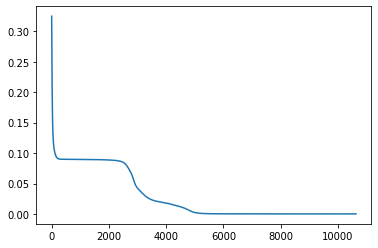

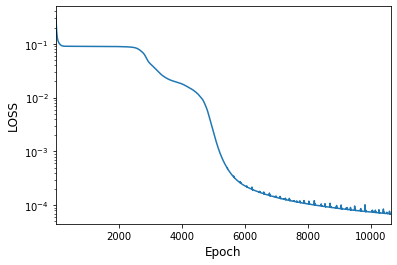

In [37]:
# check the loss
epo = np.linspace(0, len(model.loss_all[1:]), len(model.loss_all[1:]))
plt.plot(epo, model.loss_all[1:])
plt.show()

plt.semilogy(epo, model.loss_all[1:])
plt.xlim(1, epo[-1])
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('LOSS', fontsize = 12)
plt.show()

In [12]:
# calculate output

whole_test = np.array(np.zeros((Nx * 1000, 2)))
ts = np.linspace(0, 1, 1001)
n = 0
for i in range(Nx):
    for j in range(1000):
        whole_test[n, 0] = x[i]
        whole_test[n, 1] = ts[j]
        n = n + 1
        
u_p = model.estimation(whole_test[:, 0:1], whole_test[:, 1:2])
u_pred2 = np.array(np.zeros((Nx, 1000)))
n = 0
for i in range(Nx):
    for j in range(1000):
        u_pred2[i, j] = u_p[n]
        n = n + 1

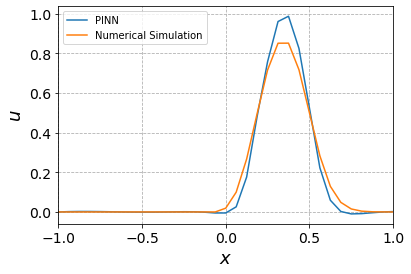

In [36]:
# compare PINN with simulation

tt = 100
#fig = plt.figure(figsize=(10, 7))
plt.plot(x, u_pred2[:, tt], label = 'PINN')
plt.plot(x, u_t[:, tt], label = 'Numerical Simulation')
plt.legend()
plt.grid(linestyle='--')
plt.xlim(-1,1)
#plt.ylim(0.9,2.2)
plt.tick_params(labelsize=14)
plt.ylabel('$u$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.show()

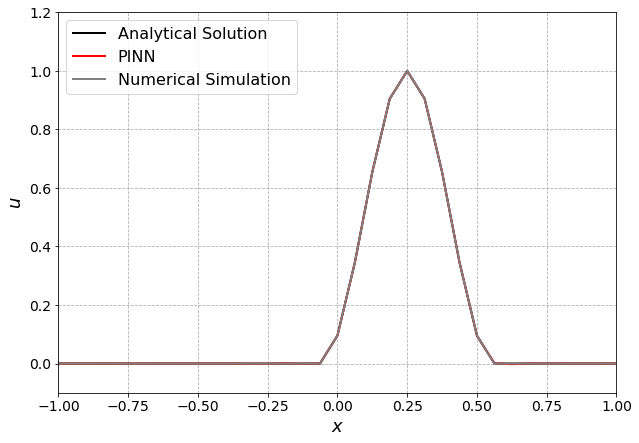

In [76]:
from matplotlib import animation
fig = plt.figure(figsize=(10, 7))

Writer = animation.writers['ffmpeg']
writer = Writer(fps = 4, metadata = dict(artist='me'), bitrate=3000)

def update(i):

    plt.cla()                      # 現在描写されているグラフを消去

    
    
    plt.plot(x_true+i*dt, u_true[:, 0], 'k', lw=2, label = 'Analytical Solution')
    plt.plot(x, u_pred2[:, i], 'r', lw=2, label = 'PINN')
    plt.plot(x, u_t[:, i], 'gray', lw=2, label = 'Numerical Simulation')

    plt.legend(loc='upper left', fontsize = 16)
    plt.xlim(-1,1)
    plt.ylim(-0.1,1.2)
    plt.grid(linestyle='--')
    plt.tick_params(labelsize=14)
    plt.ylabel('$u$', fontsize=18)
    plt.xlabel(r'$x$', fontsize=18)


ani = animation.FuncAnimation(fig, update, interval = 2, frames = 1000)

ani.save('./Convection.mp4', fps=200)